# Установка библиотек

In [ ]:
!nvidia-smi

Tue Feb  3 11:33:32 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install --upgrade ultralytics

  Using cached ultralytics-8.4.10-py3-none-any.whl.metadata (38 kB)
Using cached ultralytics-8.4.10-py3-none-any.whl (1.2 MB)
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.3.40
    Uninstalling ultralytics-8.3.40:
      Successfully uninstalled ultralytics-8.3.40


In [ ]:
!pip install -q supervision "ultralytics<=8.3.40"

In [ ]:
!pip install --upgrade roboflow

In [ ]:
!yolo settings sync=False

JSONDict("/root/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/content/datasets",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb",
  "sync": false,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": true,
  "wandb": false,
  "vscode_msg": true
}
💡 Learn more about Ultralytics Settings at https://docs.ultralytics.com/quickstart/#ultralytics-settings


In [ ]:
import cv2

import numpy as np
import supervision as sv

from tqdm import tqdm
from ultralytics import YOLO
from supervision.assets import VideoAssets, download_assets
from collections import defaultdict, deque

WARNING ⚠️ Ultralytics settings reset to default values. This may be due to a possible problem with your settings or a recent ultralytics package update. 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Загрузка данных

In [ ]:
download_assets(VideoAssets.VEHICLES)

vehicles.mp4 asset download complete. 



'vehicles.mp4'

In [ ]:
model = YOLO(MODEL_NAME)

# Аннотация и маркировка

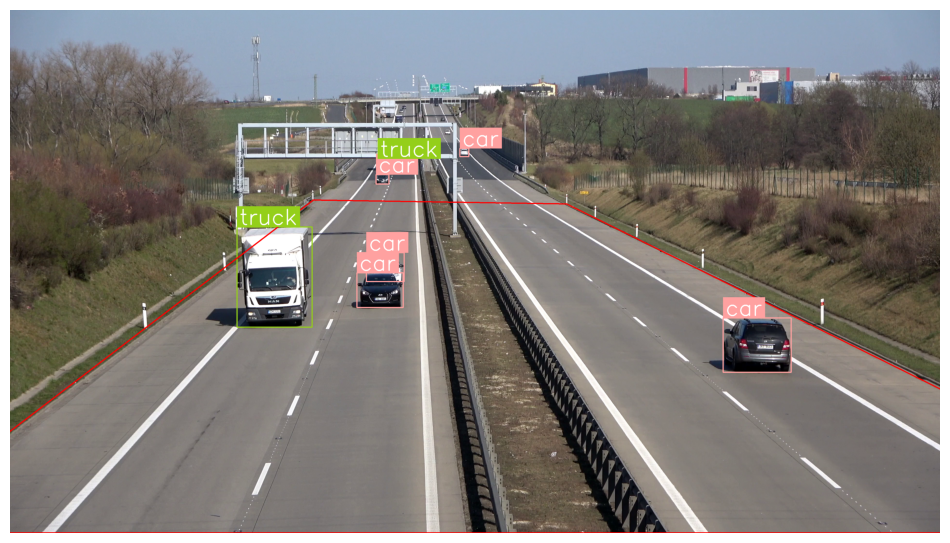

In [ ]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame = next(frame_generator)

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)

label_annotator = sv.LabelAnnotator(text_scale=3, text_thickness=3)

box_annotator = sv.BoxAnnotator(thickness=4)

result = model.predict(frame, imgsz=1280, verbose=False)[0]

detections = sv.Detections.from_ultralytics(result)

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SOURCE, color = sv.Color.RED, thickness=4)
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections)

sv.plot_image(annotated_frame)

# Добавление отслеживания ByteTrack

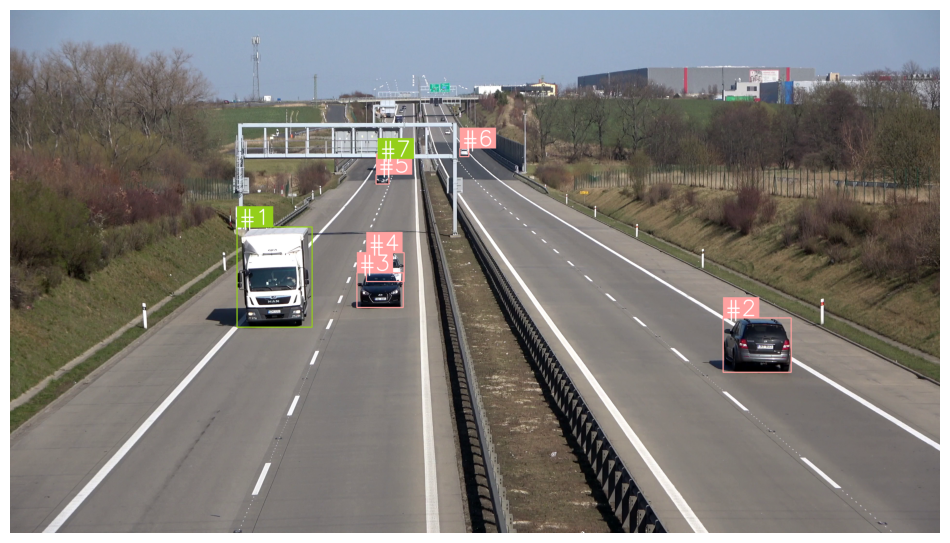

In [ ]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame = next(frame_generator)

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
tracker = sv.ByteTrack(frame_rate=video_info.fps)

label_annotator = sv.LabelAnnotator(text_scale=3, text_thickness=3)

box_annotator = sv.BoxAnnotator(thickness=4)

result = model.predict(frame, imgsz=1280, verbose=False)[0]

detections = sv.Detections.from_ultralytics(result)
detections = tracker.update_with_detections(detections=detections)

labels = [
    f'#{tracker_id}'
    for tracker_id
    in detections.tracker_id
]


annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

sv.plot_image(annotated_frame)

# Нахождение координат транспортов

In [ ]:
import cv2

class ViewTransformer:
    def __init__(self, source: np.ndarray, target: np.ndarray):
        source = source.astype(np.float32)
        target = target.astype(np.float32)

        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)

        return transformed_points.reshape(-1, 2)

In [ ]:
SOURCE = np.array([
    [1252, 787],
    [2298, 803],
    [5039, 2159],
    [-550, 2159]
])

TARGET_WIDTH = 25
TARGET_HEIGHT = 250

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
])

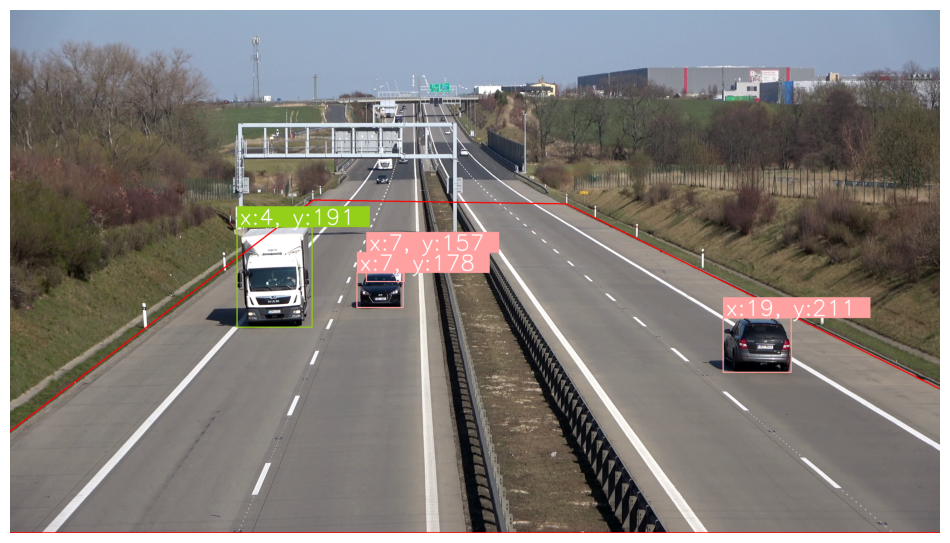

In [ ]:
import numpy as np

frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame = next(frame_generator)

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)

polygon_zone = sv.PolygonZone(SOURCE)
view_transformer = ViewTransformer(source=SOURCE, target=TARGET)

tracker = sv.ByteTrack(frame_rate=video_info.fps)

label_annotator = sv.LabelAnnotator(text_scale=3, text_thickness=3)

box_annotator = sv.BoxAnnotator(thickness=4)

result = model.predict(frame, imgsz=1280, verbose=False)[0]

detections = sv.Detections.from_ultralytics(result)
detections = detections[polygon_zone.trigger(detections)]
detections = tracker.update_with_detections(detections=detections)

points = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
points = view_transformer.transform_points(points=points).astype(int)

labels = [
    f'x:{x}, y:{y} '
    for [x, y]
    in points
]


annotated_frame = frame.copy()
annotated_frame = sv.draw_polygon(annotated_frame, polygon=SOURCE, color = sv.Color.RED, thickness=4)
annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

sv.plot_image(annotated_frame)

# Выявление скорости и сохранение видео

In [ ]:
import numpy as np

frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)

polygon_zone = sv.PolygonZone(SOURCE)
view_transformer = ViewTransformer(source=SOURCE, target=TARGET)

coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

tracker = sv.ByteTrack(frame_rate=video_info.fps)

label_annotator = sv.LabelAnnotator(text_scale=3, text_thickness=3)

box_annotator = sv.BoxAnnotator(thickness=4)


with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        result = model.predict(frame, imgsz=1280, verbose=False)[0]

        detections = sv.Detections.from_ultralytics(result)
        detections = detections[polygon_zone.trigger(detections)]
        detections = tracker.update_with_detections(detections=detections)

        points = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
        points = view_transformer.transform_points(points=points).astype(int)


        labels = []
        for tracker_id, [_,y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                labels.append(f"{tracker_id}")
            else:
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6
                labels.append(f'#{tracker_id} {int(speed)} km/h')

        annotated_frame = frame.copy()
        annotated_frame = sv.draw_polygon(annotated_frame, polygon=SOURCE, color = sv.Color.RED, thickness=4)
        annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

        sink.write_frame(annotated_frame)

100%|██████████| 538/538 [02:05<00:00,  4.28it/s]
